In [1]:
import asyncio, json, time, httpx, nest_asyncio
from pathlib import Path
from typing import Optional, Dict, List
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.asyncio import tqdm_asyncio
import pycountry


nest_asyncio.apply()                   # nested loops ok in Jupyter

In [2]:
# ---------- IO ----------
OUTPUT_DIR = Path("output").resolve(); OUTPUT_DIR.mkdir(exist_ok=True)
CACHE_DIR  = Path(".cache").resolve(); CACHE_DIR.mkdir(exist_ok=True)

# ---------- Window ----------
START_YR, END_YR = 1950, 2025
PERIOD = 3
DECADES = list(range(1950, 2030, 10))

# ---------- Topic IDs ----------
TOPIC_IDS = [
    "t11637","t10022","t11853","t10590","t10361",
    "t10099","t10472","t13889","t11429","t12529"
]
TOPIC_FILTER = "primary_topic.id:" + "|".join(TOPIC_IDS)

# ---------- HTTP throttle ----------
UA = "semi-pubs/1.0"
RPS_LIMIT   = 8
MIN_INTERVAL = 1.0 / RPS_LIMIT
MAX_RETRIES  = 5
_last_ts = 0.0
_rate_lock = asyncio.Lock()

# ---------- Region buckets ----------
US_SET = {"US"}
ASIA_SET = {
    "CN","JP","KR","TW","IN","IL","SG","HK","MY","TH","VN","ID","PH","PK",
    "BD","LK","MM","NP","KZ","UZ","TJ","QA","AE","KW","SA","IR","OM","YE",
    "JO","IQ","GE","AM","AZ","CY","BN"
}
EU_SET = {
    "DE","FR","GB","IT","NL","SE","FI","BE","CH","ES","IE","DK","AT","NO",
    "PL","CZ","HU","PT","GR","RU","UA","LT","LV","EE","SI","SK","HR","BG",
    "RO","LU","MT","LI","AL","ME","MK"
}
def iso_to_region(code: str) -> str:
    code = (code or "").upper()
    if code in US_SET:   return "US"
    if code in ASIA_SET: return "Asia"
    if code in EU_SET:   return "Europe"
    return "Rest"

In [3]:
def normalize_name(name: str) -> str:
    """Lowercase, strip punctuation; crude but effective."""
    import re, unicodedata
    name = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode()
    return re.sub(r"[^\w\s]", "", name).lower().strip()

In [4]:
def cache_path(key:str) -> Path: return CACHE_DIR / f"{key}.json"

async def fetch_json(client:httpx.AsyncClient, url:str, *,
                     cache_key:Optional[str]=None) -> dict:
    if cache_key and cache_path(cache_key).exists():
        return json.loads(cache_path(cache_key).read_text())

    global _last_ts
    async with _rate_lock:
        wait = MIN_INTERVAL - (time.perf_counter()-_last_ts)
        if wait>0: await asyncio.sleep(wait)
        _last_ts = time.perf_counter()

    for attempt in range(MAX_RETRIES):
        r = await client.get(url, timeout=60)
        if r.status_code==429:
            await asyncio.sleep(2**attempt); continue
        r.raise_for_status(); data=r.json()
        if cache_key: cache_path(cache_key).write_text(json.dumps(data))
        return data
    raise RuntimeError(f"Retries exceeded: {url}")

In [ ]:
async def ultimate_parent_ror(client:httpx.AsyncClient, ror:str) -> str:
    """Walk Parent relationships until root; return root ROR."""
    cur=ror; seen=set(); last_valid_ror = ror
    while cur and cur not in seen:
        seen.add(cur)
        last_valid_ror = cur
        data = await fetch_json(client,
                 f"https://api.ror.org/organizations/{cur}",
                 cache_key=f"ror_{cur}")
        parents=[rel["id"].split('/')[-1]
                 for rel in data.get("relationships",[])
                 if rel.get("type")=="Parent"]
        cur = parents[0] if parents else None
    return last_valid_ror

In [6]:
async def region_counts_by_year() -> pd.DataFrame:
    rows=[]
    async with httpx.AsyncClient(headers={"User-Agent":UA},
                                 limits=httpx.Limits(max_connections=RPS_LIMIT)) as cli:

        # 1 year → top‑200 institution counts (company only)
        inst_rows=[]
        for yr in tqdm_asyncio(range(START_YR,END_YR+1), desc="Inst counts",ncols=80):
            url=("https://api.openalex.org/works?"
                 f"filter={TOPIC_FILTER},publication_year:{yr},"
                 "authorships.institutions.type:company"
                 "&group_by=institutions.id&sort=count:desc&per-page=200")
            for g in (await fetch_json(cli,url,cache_key=f"instyr_{yr}")).get("group_by",[]):
                inst_rows.append({"year":yr,
                                  "inst_id":g["key"].split('/')[-1],
                                  "papers":g["count"]})

        # 2 metadata & parent country
        ids={r["inst_id"] for r in inst_rows}
        meta = await tqdm_asyncio.gather(
            *[fetch_json(cli,f"https://api.openalex.org/institutions/{iid}",
                         cache_key=f"meta_{iid}") for iid in ids],
            desc="Inst meta", ncols=80)

        # parent resolution
        child2par={}
        for m in meta:
            ror=(m.get("ror") or "").split('/')[-1]
            if ror: child2par[ror]=None
        par_res = await tqdm_asyncio.gather(
            *[ultimate_parent_ror(cli,r) for r in child2par.keys()],
            desc="Parent RORs", ncols=80)
        child2par=dict(zip(child2par.keys(),par_res))

        # build meta rows
        mrows=[]
        for m in meta:
            child_ror=(m.get("ror") or "").split('/')[-1]
            par_ror  = child2par.get(child_ror,child_ror)
            pmeta = await fetch_json(
                cli,
                f"https://api.openalex.org/institutions?filter=ror:{par_ror}&per-page=1",
                cache_key=f"parmeta_{par_ror}")
            country=(pmeta["results"][0].get("country_code") or "NA") if pmeta["results"] else "NA"
            mrows.append({"inst_id":m["id"].split('/')[-1],"country":country.upper()})

    df = pd.DataFrame(inst_rows).merge(pd.DataFrame(mrows),on="inst_id",how="left")
    df["region"]=df["country"].apply(iso_to_region)
    return (df.groupby(["year","region"],observed=True)["papers"]
              .sum().reset_index())


In [7]:
# ═══════════════════════════════════════════════════════════════════
#  Parent‑consolidated Top‑50 Publishers per Decade (Async)
#  • Subsidiaries collapsed to ultimate parent ROR
#  • Orphan subsidiaries (no ROR) merged by display‑name match
#  • Region bucket = "US" vs "Rest" from parent HQ country
# ═══════════════════════════════════════════════════════════════════

async def top50_by_decade() -> pd.DataFrame:
    rows = []
    async with httpx.AsyncClient(headers={"User-Agent": UA},
                                 limits=httpx.Limits(max_connections=RPS_LIMIT)) as cli:

        # ── 1. Collect up to 200 subsidiaries per decade ──────────────
        for start in tqdm_asyncio(DECADES, desc="Decade inst fetch", ncols=80):
            dec_label = f"{start}-{start+9}"
            url = (
                "https://api.openalex.org/works?"
                f"filter={TOPIC_IDS and ('primary_topic.id:' + '|'.join(TOPIC_IDS) + ',')}"
                f"publication_year:{start}-{start+9},"
                "authorships.institutions.type:company"
                "&group_by=institutions.id"
                "&sort=count:desc&per-page=200"     # enough coverage for parents
            )
            for g in (await fetch_json(cli, url, cache_key=f"dec_inst_{dec_label}")).get("group_by", []):
                rows.append({
                    "decade": dec_label,
                    "inst_id": g["key"].split('/')[-1],
                    "count": g["count"]
                })

        # ── 2. Fetch child institution metadata ──────────────────────
        inst_ids = {r["inst_id"] for r in rows}
        meta_json = await tqdm_asyncio.gather(
            *[fetch_json(cli, f"https://api.openalex.org/institutions/{iid}",
                         cache_key=f"meta_{iid}") for iid in inst_ids],
            desc="Inst meta", ncols=80
        )

        # ---- Build child_ror → parent_ror map -----------------------
        child2parent: Dict[str, str] = {}
        for m in meta_json:
            ror = (m.get("ror") or "").split('/')[-1]
            if ror:
                child2parent[ror] = None  # placeholder
        # resolve ultimate parents
        parent_list = list(child2parent.keys())
        resolved_parents = await tqdm_asyncio.gather(
            *[ultimate_parent_ror(cli, r) for r in parent_list],
            desc="Resolve parent RORs", ncols=80
        )
        child2parent = dict(zip(parent_list, resolved_parents))

        # ---- parent metadata (name + country) -----------------------
        parent_meta: Dict[str, Dict[str, str]] = {}
        for par_ror in set(child2parent.values()):
            pj = await fetch_json(
                cli,
                f"https://api.openalex.org/institutions?filter=ror:{par_ror}&per-page=1",
                cache_key=f"parmeta_{par_ror}")
            if pj["results"]:
                entry = pj["results"][0]
                parent_meta[par_ror] = {
                    "name": entry["display_name"],
                    "country": (entry.get("country_code") or "NA").upper()
                }

    # ── 3. Merge child → parent, with name‑based fallback ───────────
    name2parent = {normalize_name(v["name"]): pid for pid, v in parent_meta.items()}

    meta_rows = []
    for m in meta_json:
        child_id   = m["id"].split('/')[-1]
        child_ror  = (m.get("ror") or "").split('/')[-1]
        parent_ror = child2parent.get(child_ror)

        # fallback by normalized name if ROR missing
        if not parent_ror:
            parent_ror = name2parent.get(normalize_name(m["display_name"]))

        # if still none, treat itself as parent
        parent_ror = parent_ror or child_ror or child_id

        pinfo = parent_meta.get(parent_ror, {
            "name": m["display_name"],
            "country": (m.get("country_code") or "NA").upper()
        })
        meta_rows.append({
            "inst_id": child_id,
            "parent_ror": parent_ror,
            "parent_name": pinfo["name"],
            "parent_country": pinfo["country"]
        })

    # ── 4. Aggregate counts at parent level ─────────────────────────
    df_child = pd.DataFrame(rows)
    df_meta  = pd.DataFrame(meta_rows)
    merged   = df_child.merge(df_meta, on="inst_id", how="left")
    agg = (merged.groupby(["decade", "parent_ror", "parent_name", "parent_country"])
                 ["count"].sum().reset_index())

    # rank and slice top‑50 per decade
    agg["rank"] = agg.groupby("decade")["count"].rank(method="first", ascending=False)
    top50 = agg[agg["rank"] <= 50].copy()
    top50.sort_values(["decade", "count"], ascending=[True, False], inplace=True)
    top50["region_group"] = top50["parent_country"].apply(lambda c: "US" if c == "US" else "Rest")

    # tidy columns
    top50 = top50[["decade", "rank", "parent_name", "parent_country", "count", "region_group"]]
    top50.rename(columns={"parent_name": "name", "parent_country": "country"}, inplace=True)
    return top50


In [8]:
%%time
df_reg_year = asyncio.run(region_counts_by_year())
df_top50dec = asyncio.run(top50_by_decade())

Resolve parent RORs: 100%|██████████████████| 719/719 [00:00<00:00, 7428.48it/s]


CPU times: user 18.1 s, sys: 1.77 s, total: 19.8 s
Wall time: 14min 7s


region,Asia,Europe,Rest,US
period,,,,
1950-1952,4,8,0,15
1953-1955,12,10,0,58
1956-1958,11,20,2,87
1959-1961,49,42,5,162
1962-1964,44,67,14,234


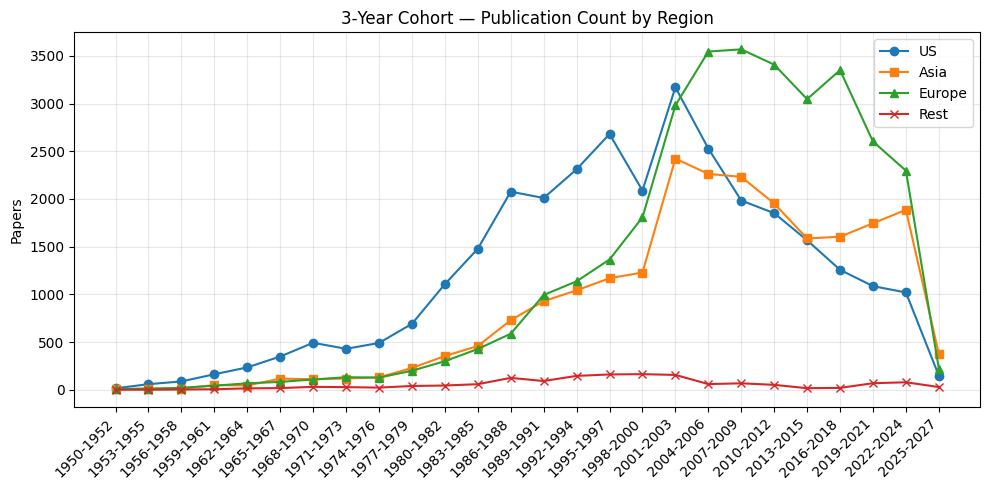

In [9]:
def assign_period(y:int)->str:
    start=START_YR+((y-START_YR)//PERIOD)*PERIOD
    return f"{start}-{start+PERIOD-1}"

df_reg_year["period"]=df_reg_year["year"].apply(assign_period)
cohort=(df_reg_year.groupby(["period","region"],observed=True)["papers"]
        .sum().unstack(fill_value=0)
        .sort_index(key=lambda idx:idx.map(lambda s:int(s.split('-')[0]))))
display(cohort.head())
fig,ax=plt.subplots(figsize=(10,5))
for reg,m in zip(["US","Asia","Europe","Rest"],["o","s","^","x"]):
    if reg in cohort.columns:
        ax.plot(cohort.index,cohort[reg],marker=m,label=reg)
ax.set_title("3‑Year Cohort — Publication Count by Region")
ax.set_ylabel("Papers"); ax.grid(alpha=.3); ax.legend()
plt.xticks(rotation=45,ha="right"); plt.tight_layout(); plt.show()


region,Asia,Europe,Rest,US
decade,,,,
1950,40,49,3,206
1960,272,262,51,1037
1970,509,482,102,1763
1980,1798,1641,252,5305
1990,3711,4366,476,7771


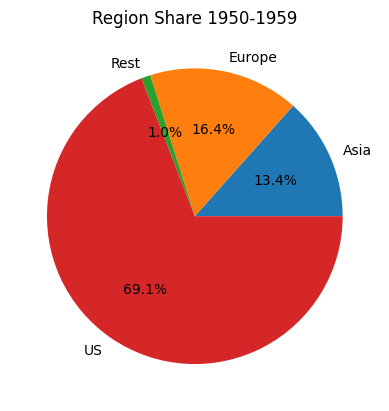

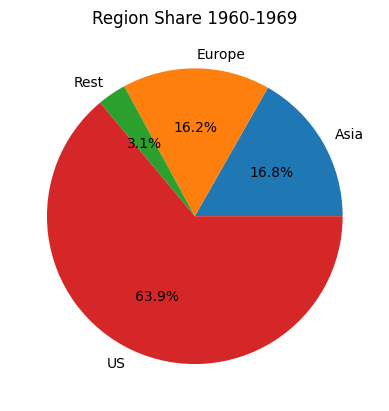

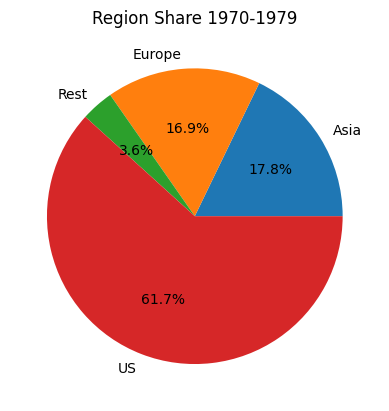

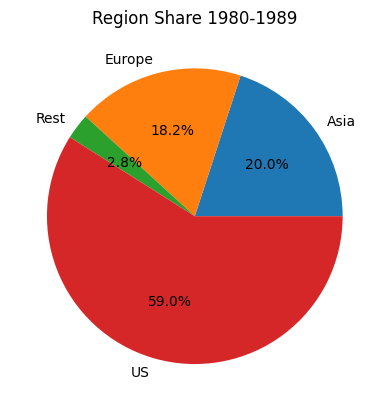

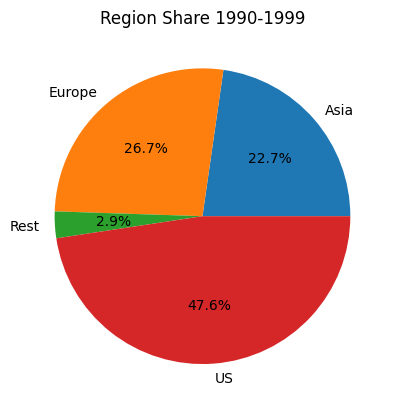

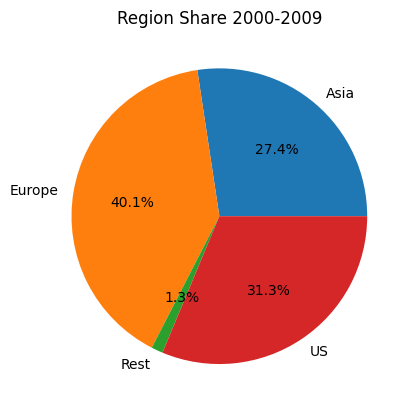

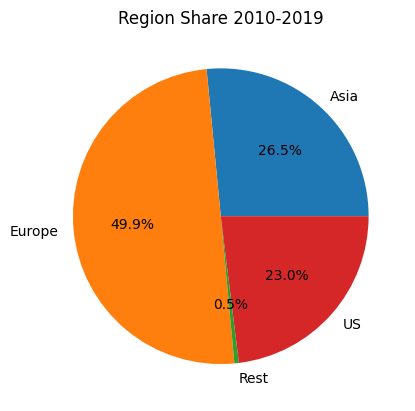

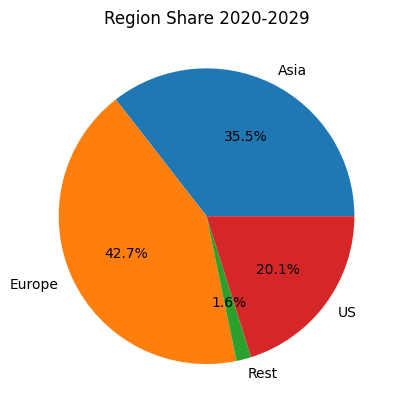

In [10]:
dec_tbl=(df_reg_year.assign(decade=lambda d:(d["year"]//10)*10)
         .groupby(["decade","region"],observed=True)["papers"]
         .sum().unstack(fill_value=0))
display(dec_tbl.head())
for dec,row in dec_tbl.iterrows():
    fig,ax=plt.subplots(); ax.pie(row,labels=row.index,autopct='%1.1f%%')
    ax.set_title(f"Region Share {dec}-{dec+9}"); plt.show()


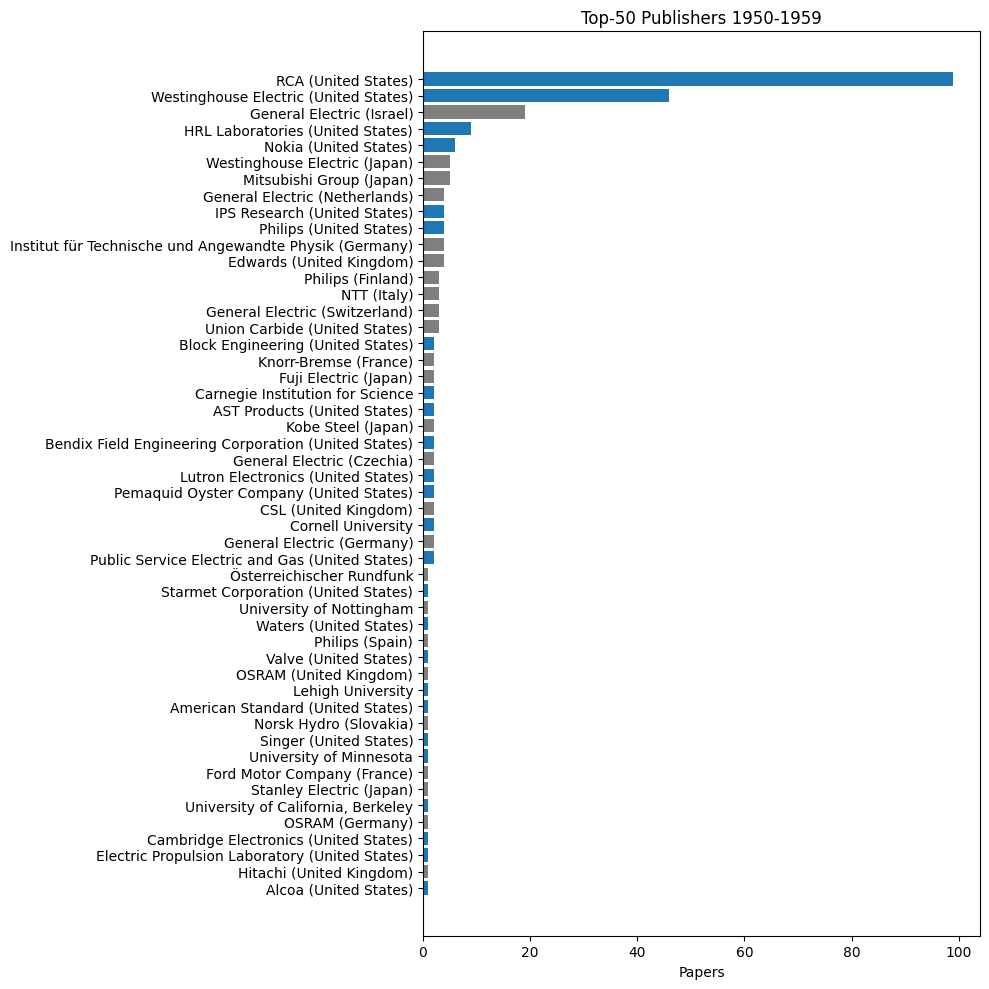

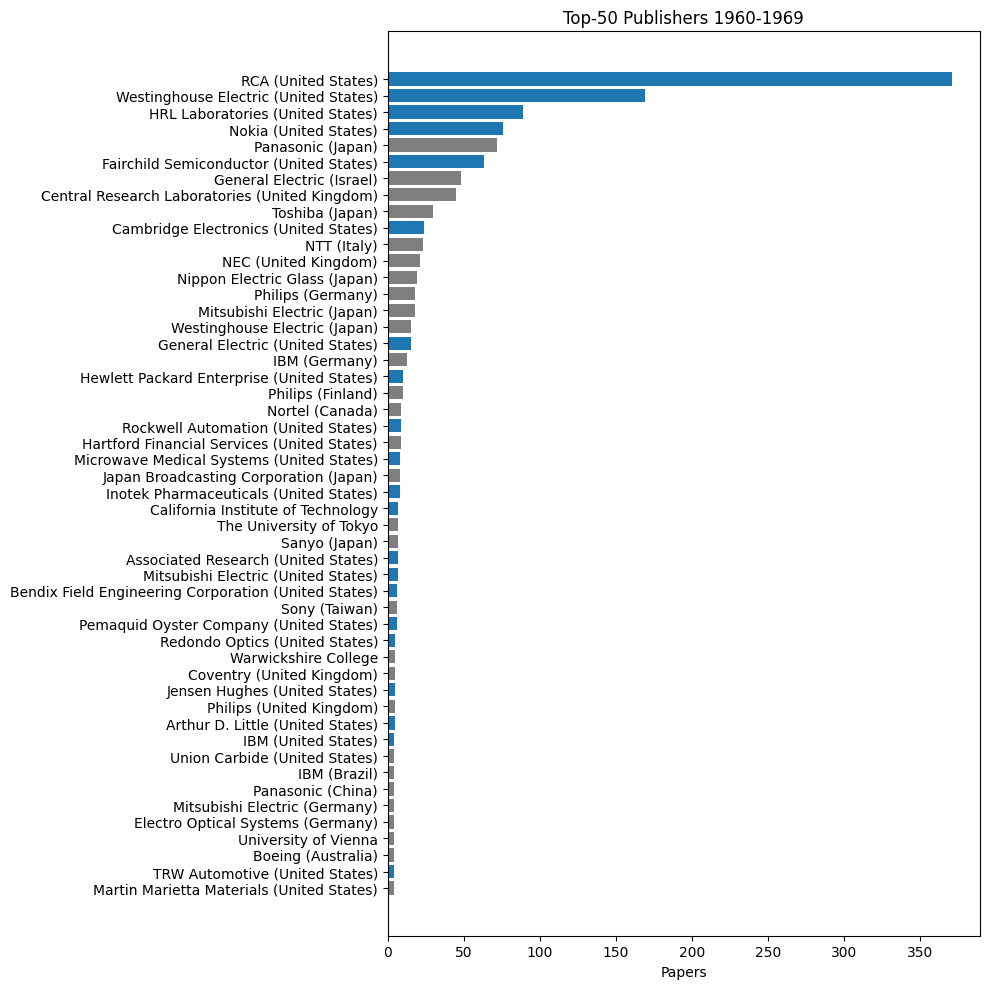

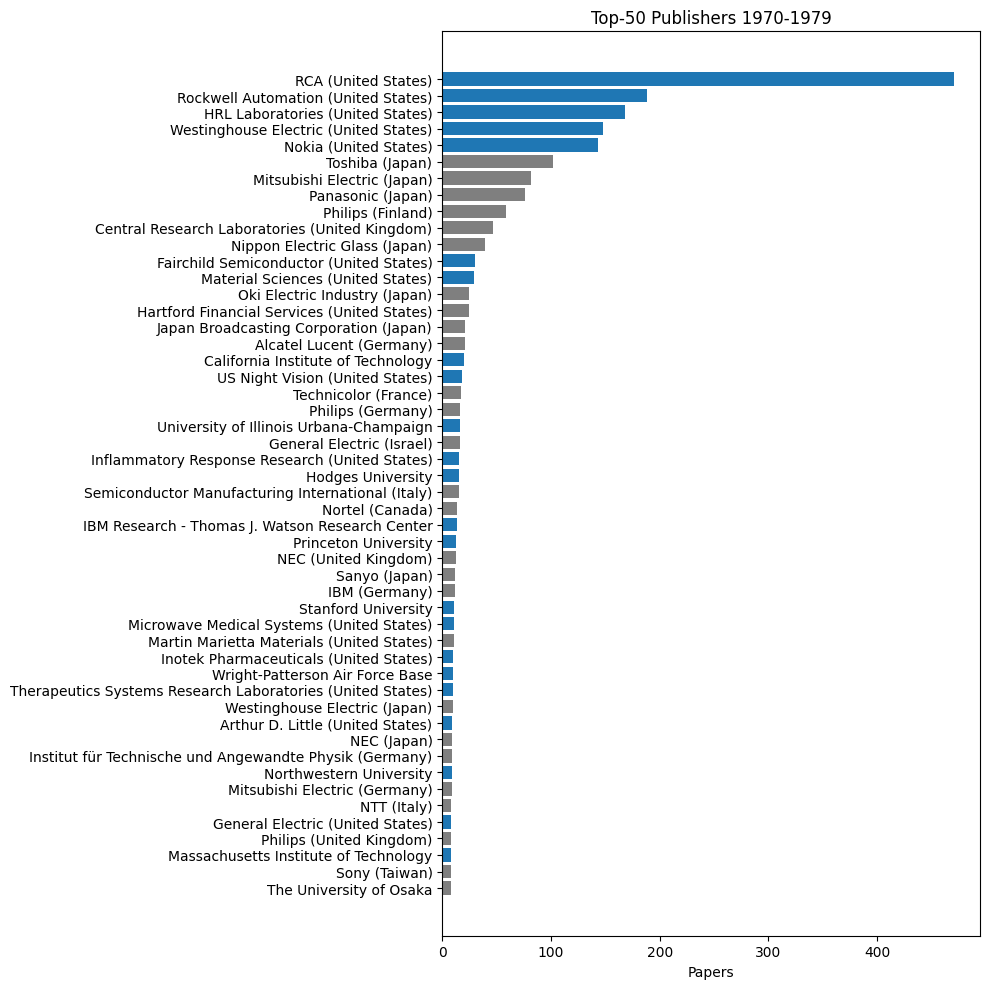

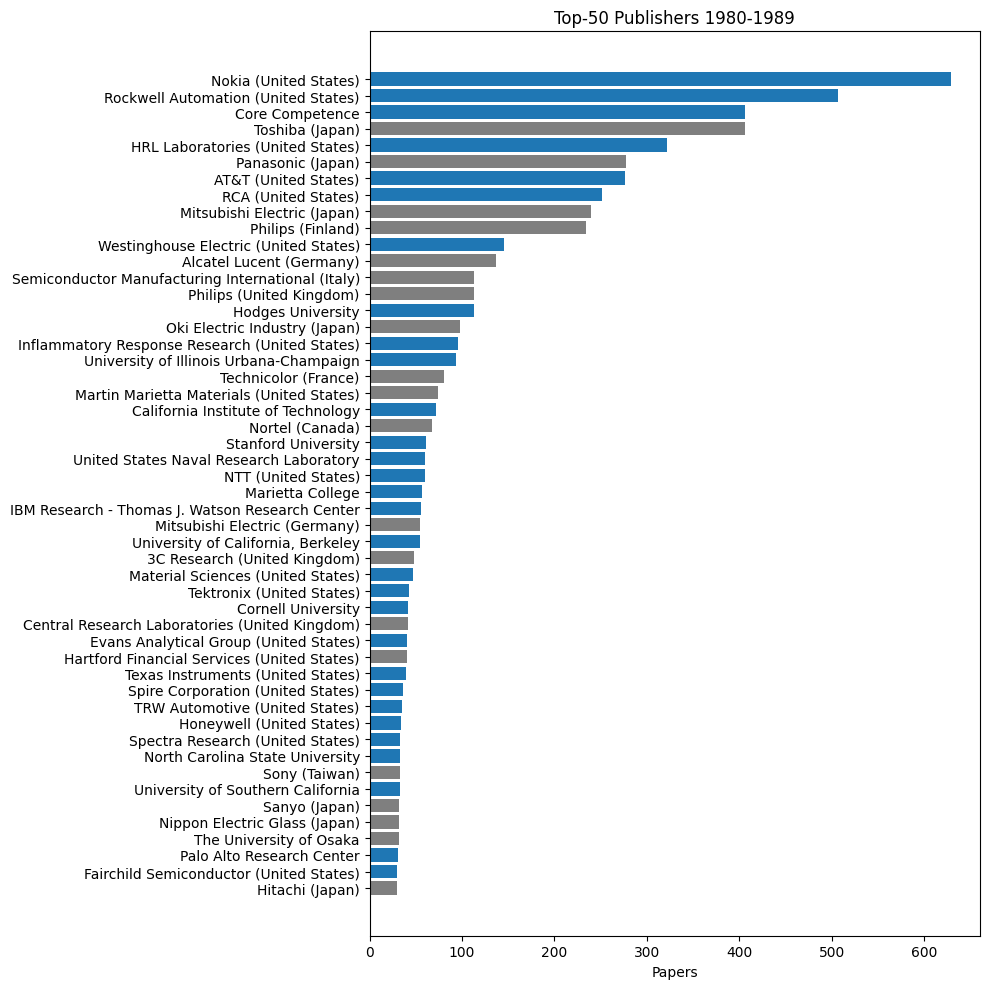

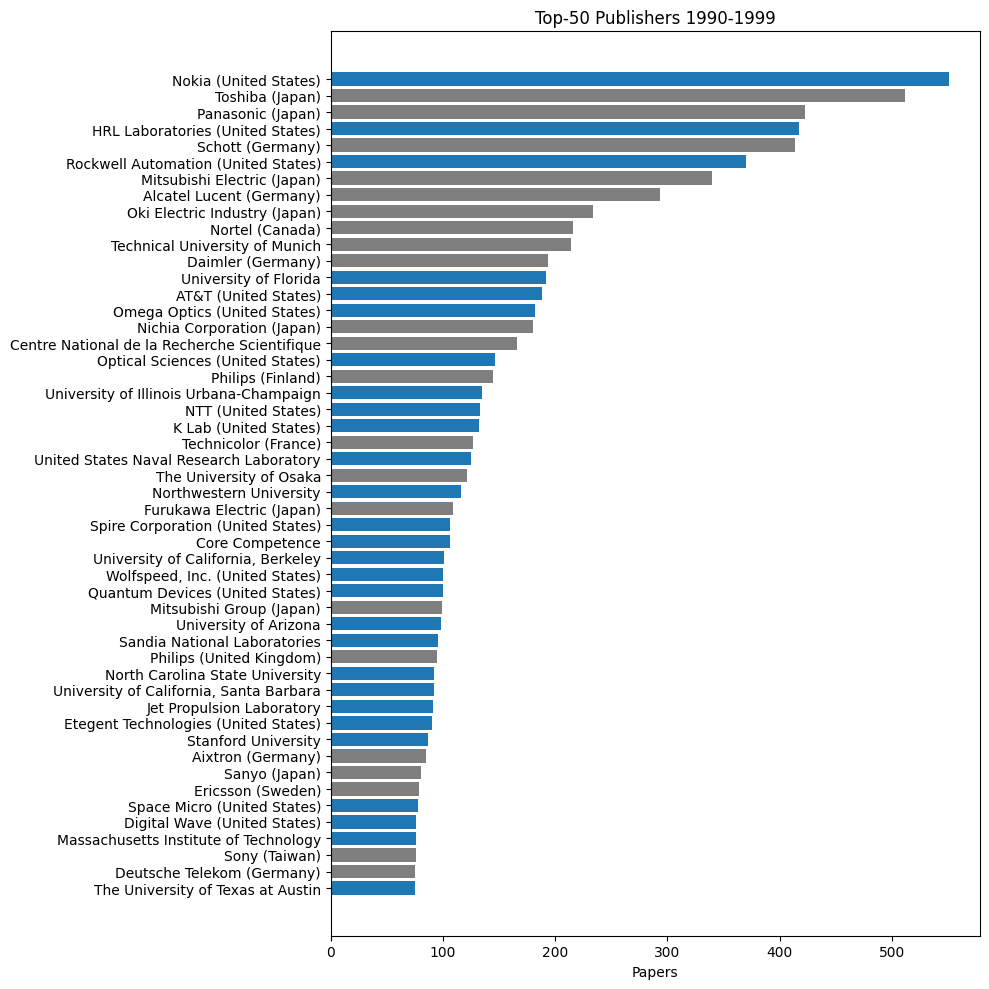

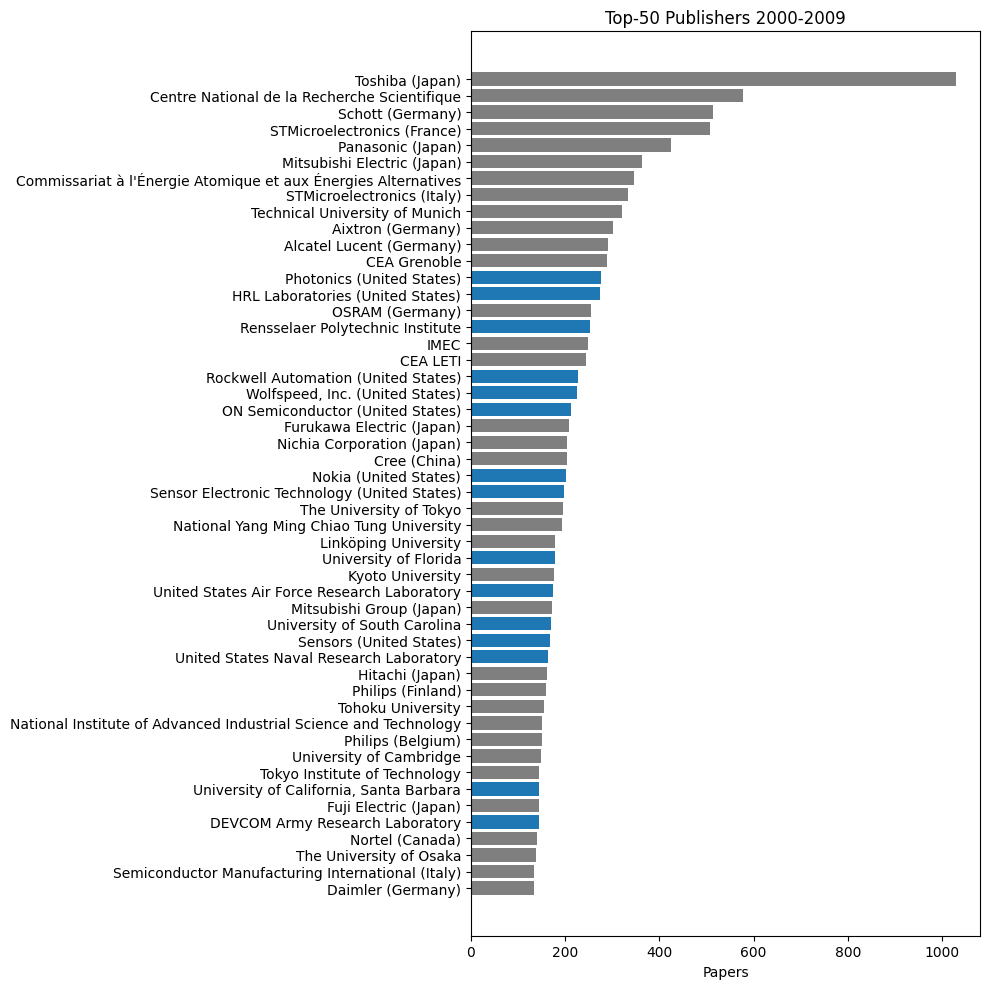

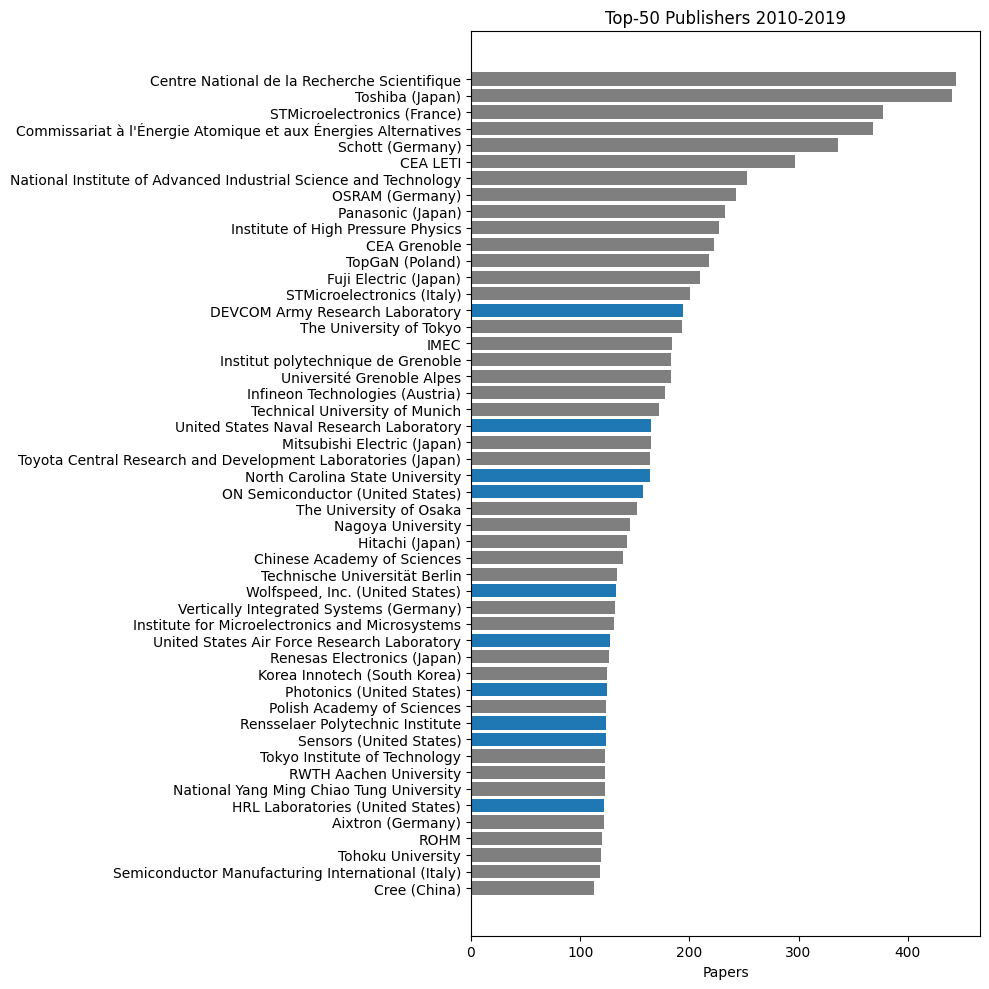

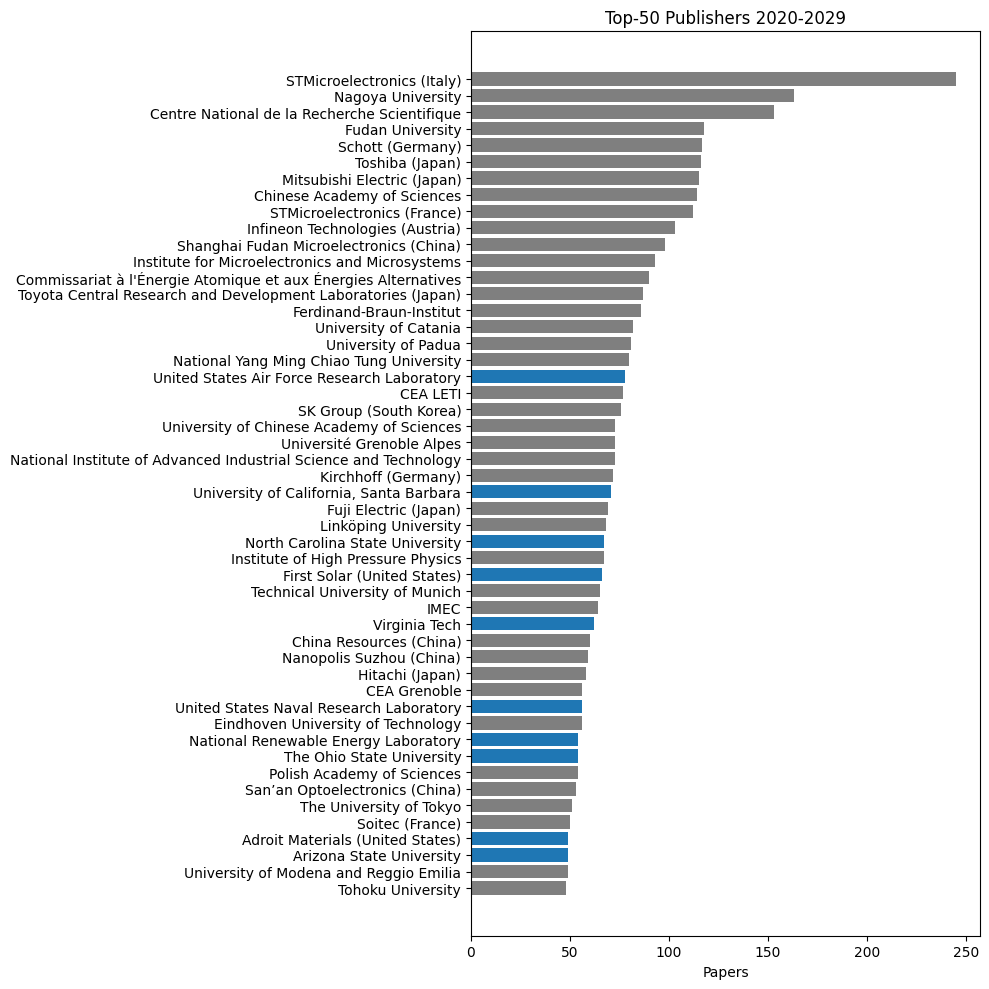

In [11]:
for dec in DECADES:
    label=f"{dec}-{dec+9}"
    sl=df_top50dec[df_top50dec["decade"]==label].sort_values("count",ascending=True)
    colors=sl["region_group"].map({"US":"tab:blue","Rest":"tab:gray"})
    fig,ax=plt.subplots(figsize=(10,10))
    ax.barh(sl["name"],sl["count"],color=colors)
    ax.set_title(f"Top‑50 Publishers {label}"); ax.set_xlabel("Papers")
    plt.tight_layout(); plt.show()